In [1]:
import pydriller
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
from IPython import display
import pandas as pd

**Task 1: Author analysis**

In [2]:
elastic_path = "C:\\Users\\luist\\OneDrive\\Escritorio\\SOSY-SE-ASSIGNMENT\\elastic\\elasticsearch"

In [3]:
repo = pydriller.Repository(elastic_path, from_tag="v1.0.0", to_tag="v1.1.0")

In [7]:
# with this code we can check if some files have been renamed/removed

#for c in repo.traverse_commits():
#    for mf in c.modified_files:
#        if mf.old_path and (mf.new_path != mf.old_path):
#            print(mf.old_path, "->", mf.new_path)
            
# we have two cases:
# old_name --> new_name (renamed) : here we consider the new path (we could also consider the old_path)
# old_name --> None (removed) : here we consider the old_path
#
# we have also:
# old_name == new_name (modified file) : here we consider the new path
# None --> new_name (created) : here we consider the new path

In [9]:
# we create the dictionary author => number of modified files

authors_nmodif_dictionary = {}

for c in repo.traverse_commits():
    for mf in c.modified_files:
        if mf.new_path:
            if mf.new_path.endswith('.java'):
                if c.author.name not in authors_nmodif_dictionary:
                    authors_nmodif_dictionary[c.author.name] = 1
                else:
                    authors_nmodif_dictionary[c.author.name] += 1 
        else:
            if mf.old_path.endswith('.java'):
                if c.author.name not in authors_nmodif_dictionary:
                    authors_nmodif_dictionary[c.author.name] = 1
                else:
                    authors_nmodif_dictionary[c.author.name] += 1  
authors_nmodif_dictionary = {k: v for k, v in sorted(authors_nmodif_dictionary.items(), key=lambda item: item[1], reverse=True)}

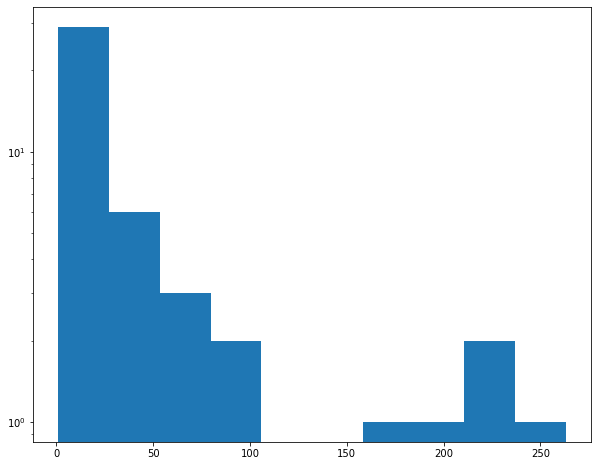

In [10]:
# visualization: number of authors (y) who modified n files (x)

plt.figure(figsize=(10,8))
plt.hist(list(authors_nmodif_dictionary.values()), bins=10)
plt.yscale('log')
plt.show()

In [11]:
# we create the dictionary file => number of authors

file_author_dictionary = {}
for c in repo.traverse_commits():
    author = c.author.name
    for mf in c.modified_files:
        if mf.new_path:
            if mf.new_path.endswith('.java'):
                if mf.new_path not in file_author_dictionary:
                    file_author_dictionary[mf.new_path] = set([author])
                else:
                    file_author_dictionary[mf.new_path].add(author)
        else:
            if mf.old_path.endswith('.java'):
                if mf.new_path not in file_author_dictionary:
                    file_author_dictionary[mf.new_path] = set([author])
                else:
                    file_author_dictionary[mf.new_path].add(author)
file_author_dictionary = {k: len(v) for k, v in file_author_dictionary.items()}
file_author_dictionary = {k: v for k, v in sorted(file_author_dictionary.items(), key=lambda item: item[1], reverse=True)}

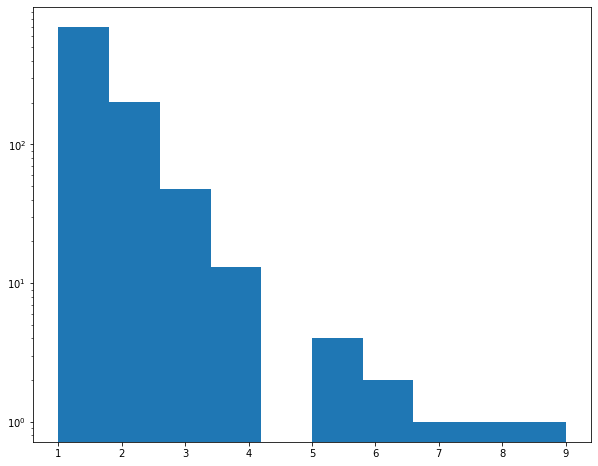

In [12]:
# visualization: number files (y) with n authors (x)

plt.figure(figsize=(10,8))
plt.hist(list(file_author_dictionary.values()), bins=10)
plt.yscale('log')
plt.show()

In [13]:
from enum import Enum

class Modification(Enum):
    ADDED = "Lines added"
    REMOVED = "Lines removed"
    TOTAL = "Lines added + lines removed"
    DIFF = "Lines added - lines removed"

In [14]:
def count_lines(operation, file):
    if operation == Modification.ADDED:
        return file.added_lines
    elif operation == Modification.REMOVED:
        return file.deleted_lines
    elif operation == Modification.DIFF:
        return file.added_lines - file.deleted_lines
    elif operation == Modification.TOTAL:
        return file.added_lines + file.deleted_lines
    else:
        raise "Invalid operation"
        
def get_modification_loc(operation, filepath):
    res = {}
    for c in repo.traverse_commits():
        author = c.author.name
        for mf in c.modified_files:
            # if the file has been removed, we checked if it was removed from the corresponding path
            if not mf.new_path:
                if mf.old_path.startswith(filepath):
                    if author not in res:
                        res[author] = count_lines(operation, mf)
                    else:
                        res[author] += count_lines(operation, mf)
            # if the file has been added, we checked if it was added the to corresponding path
            elif not mf.old_path:
                if mf.new_path.startswith(filepath):
                    if author not in res:
                        res[author] = count_lines(operation, mf)
                    else:
                        res[author] += count_lines(operation, mf)
            # otherwise, we checked if the file is/was in the corresponding path
            else:
                if mf.new_path.startswith(filepath) or mf.old_path.startswith(filepath):
                    if author not in res:
                        res[author] = count_lines(operation, mf)
                    else:
                        res[author] += count_lines(operation, mf)

                            
    return {k: v for k, v in sorted(res.items(), key=lambda item: item[1], reverse=True)}

In [15]:
# we get the contributions for the three indicated packages

filepath = "src\\main\\java\\org\\elasticsearch\\search"
author_contributions_search = get_modification_loc(Modification.TOTAL, filepath)

filepath = "src\\main\\java\\org\\elasticsearch\\index"
author_contributions_index = get_modification_loc(Modification.TOTAL, filepath)

filepath = "src\\main\\java\\org\\elasticsearch\\action"
author_contributions_action = get_modification_loc(Modification.TOTAL, filepath)

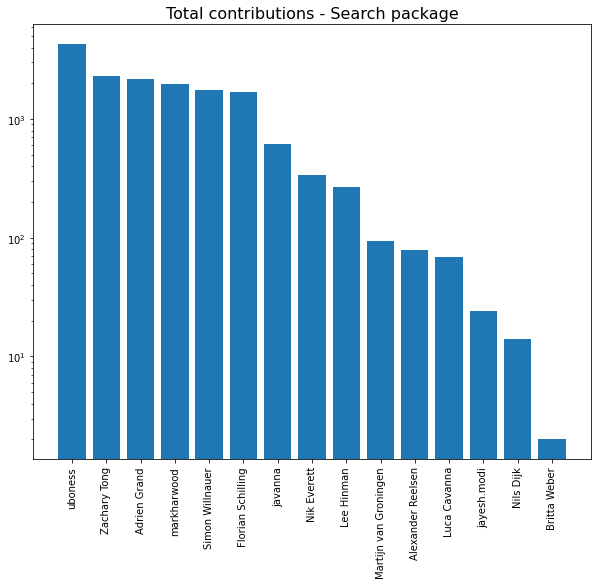

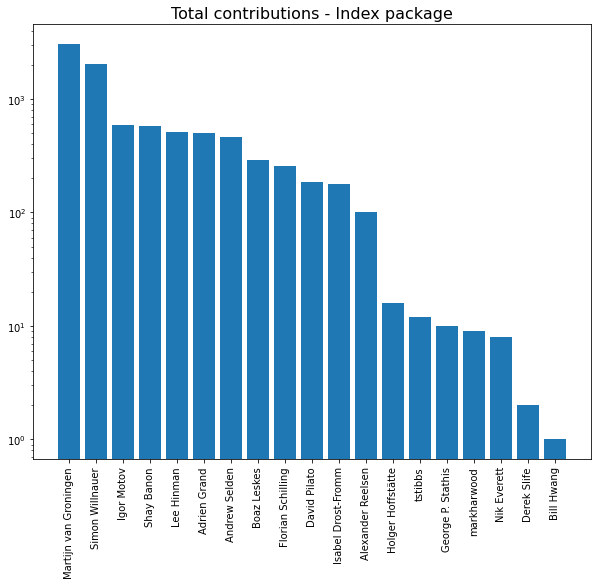

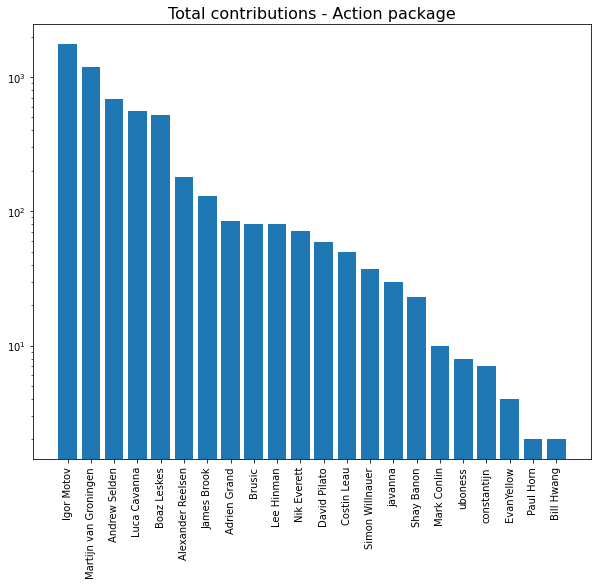

In [16]:
def plot_author_contributions(author_contributions, title):
    plt.figure(figsize=(10,8))
    plt.title(title, fontsize=16)
    plt.bar(author_contributions.keys(), author_contributions.values())
    plt.yscale('log')
    plt.xticks(rotation='vertical')
    plt.show()
    
plot_author_contributions(author_contributions_search, 'Total contributions - Search package')
plot_author_contributions(author_contributions_index, 'Total contributions - Index package')
plot_author_contributions(author_contributions_action, 'Total contributions - Action package')

**Task 2: Knowledge loss**

In [13]:
def colorFader(c1,c2,mix=0):
    c1=np.array(matplotlib.colors.to_rgb(c1))
    c2=np.array(matplotlib.colors.to_rgb(c2))
    return matplotlib.colors.to_hex((1-mix)*c1 + mix*c2)

def generate_knowledge_loss_json(author_contributions, package_name):

    total_contribution = sum(list(author_contributions.values()))

    output_json = {}
    output_json["name"] = "root"

    children_node_d = {}
    children_node_d["name"] = package_name
    children_node_d["children"] = []
    
    n = len(author_contributions)
    colors = []
    c1='red'
    c2='black'
    for x in range(n):
        colors.append(colorFader(c1,c2,x/n))
    
    children_list = []
    color_index = 0
    for contributor, contribution in author_contributions.items():
        temp = {}
        temp["author_color"] = colors[color_index]
        color_index += 1
        temp["size"] = str(contribution)
        temp["name"] = contributor
        temp["weight"] = contribution
        temp["ownership"] = contribution/total_contribution
        temp["children"] = []
        children_list.append(temp)

    children_node_d["children"] = children_list

    children_node = []
    children_node.append(children_node_d)

    output_json["children"] = children_node

    with open(f"{package_name}.json", "w") as file:
        json.dump(output_json, file, indent=4)

In [14]:
# this generates the json needed for the knowledge loss map
generate_knowledge_loss_json(author_contributions_action, "action_package")

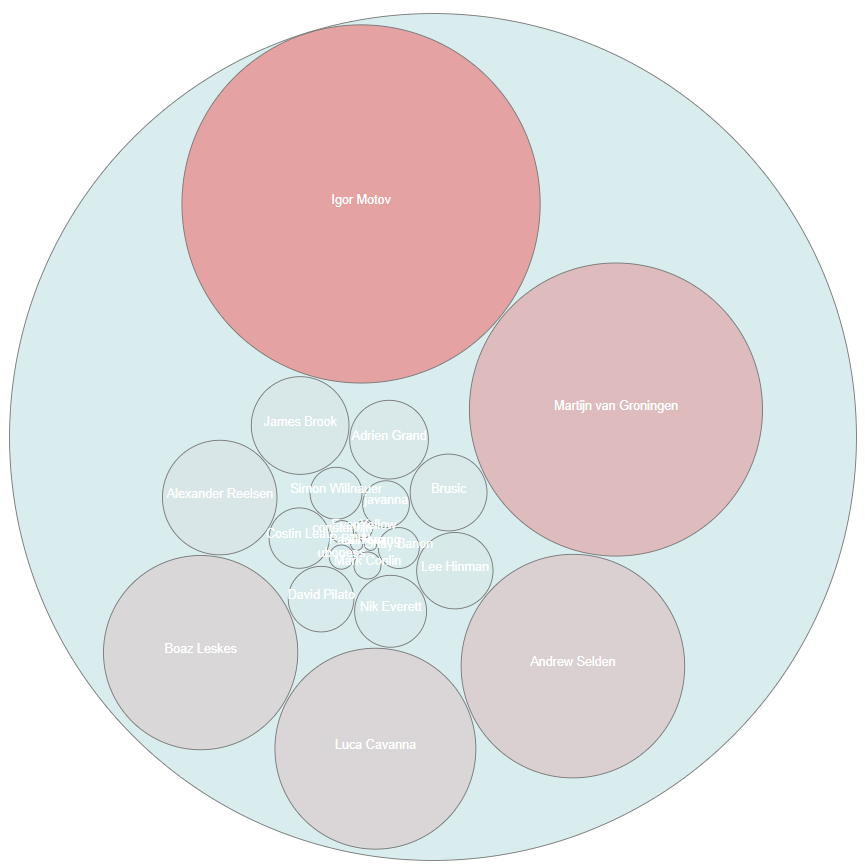

In [16]:
display.Image("knowledge_loss_map_action_package.png")

**Task 3: Code Churn Analysis**

In [36]:
churn_dictionary = {}

# generate date range and initialize dictionary
dates = []
for c in repo.traverse_commits():
    dates.append(c.author_date.strftime("%Y/%m/%d"))
date_range = pd.date_range(start=min(dates), end=max(dates))
for date in date_range:
    churn_dictionary[date.strftime("%y/%m/%d")] = 0
    
# get modified lines for each commit and populate dictionary    
for c in repo.traverse_commits():
    date = c.author_date.strftime("%y/%m/%d")
    count = 0
    for mf in c.modified_files:
        count += mf.added_lines + mf.deleted_lines
    churn_dictionary[date] += count

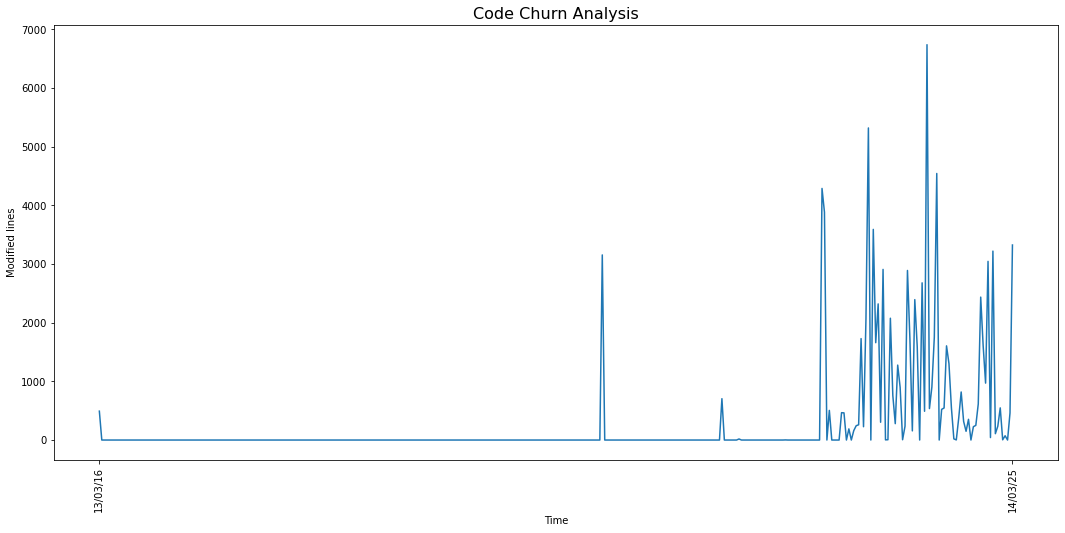

In [38]:
plt.figure(figsize=(18,8))
plt.ylabel("Modified lines")
plt.xlabel("Time")
plt.title("Code Churn Analysis", fontsize=16)
plt.plot(churn_dictionary.keys(), churn_dictionary.values())
plt.xticks([list(churn_dictionary.keys())[0], list(churn_dictionary.keys())[-1]], visible=True, rotation="vertical")
plt.show()